# Clustering of TIME magazine's most influential people 2015

Every year ** TIME ** magazine reveals a list of the 100 most influencial people on the planet. Those who make the list are divided into five categories:

* Titans
* Pioneers
* Artists
* Leaders
* Icons

In this notebook we do some Natural Language Processing in order to do clustering of these celebrities. We explore Hierarchiecal Clustering and k-Means clustering. We also do a Latent Dirichlet allocation (LDA) analysis.

As usual, we begin by loading the needed libraries

In [21]:
# We import needed libraries...
# Wikipedia library to extract biographies of people from Wikipedia information
import wikipedia
# os to interact with the operating system
import os
# Pandas to manage data analysis and data frames
import pandas as pd
# re to make use of regular expressions
import re
# argv to manage arguments in command line (in case we need it)
from sys import argv
# numpy for numerical work
import numpy as np
# nltk for natural language processing
import nltk
# For encoding and decoding 
#import codecs
# Use of sklearn to manage feature extraction
#from sklearn import feature_extraction
# 
#import mpld3

## I. Preprocessing and extracting information

We read file that contains names of celebrities and store information in a data frame

In [65]:
df = pd.read_csv("List_TIME_2015.txt",sep='\t')

In [66]:
df.head(10)

,Name,Category
0,Kayne West,Titan
1,Lorne Michaels,Titan
2,Mellody Hobson,Titan
3,Tim Cook,Titan
4,Elizabeth Holmes,Titan
5,Charles Koch & David Koch,Titan
6,Susan Wojcicki,Titan
7,Chanda Kochhar,Titan
8,Tony Fernandes,Titan
9,Lee Daniels,Titan


We turn the columns of the previous data frame into lists

In [88]:
names = list(df.Name)
category_list = list(df.Category)

In [68]:
names[:10]

['Kayne West ',
 'Lorne Michaels',
 'Mellody Hobson',
 'Tim Cook',
 'Elizabeth Holmes',
 'Charles Koch & David Koch',
 'Susan Wojcicki',
 'Chanda Kochhar',
 'Tony Fernandes',
 'Lee Daniels']

In [89]:
category_list[:10]

['Titan',
 'Titan',
 'Titan',
 'Titan',
 'Titan',
 'Titan',
 'Titan',
 'Titan',
 'Titan',
 'Titan']

The following function receives a list of names and returns list of biographies as well as a dictionary with the corresponding biographies. This function explicitly uses the Wikipedia library to extract the biographies.

In [70]:
def bio_names(list_names):
    """ 
    Function that returns list and dictionary with content of celebritie's 
    biography from Wikipedia
    list_names: list of names
    return: bio_list: list containing biography of celebrities
            bio_dict: dictionary containing biography of celebrities
    """
    bio_list = []
    bio_dict = {}
    # Set counter to zero
    k = 0
    # For each name in the list of names...
    for name in list_names:
        # We increase counter and print it along the name in turn..
        k +=1        
        print k , name
        p = wikipedia.page(name)
        # ... get the content...
        wiki_content = p.content
        # We manage content extracted from Wikipedia by eliminating the "chomp" 
        # followed by regular expressions.
        wiki_content = wiki_content.replace('\n',' ')
        wiki_content = re.sub(r'[^a-z0-9\s]', '', wiki_content.strip().lower())    
        # ... and append it to the corresponding lists and dictionaries
        bio_list.append(wiki_content)
        bio_dict[name]= wiki_content 
    # Display message to indicate we are finished
    print 'Done'
    return bio_list, bio_dict

We invoke the previously defined function

In [64]:
bio_list, bio_dict = bio_names(names)

1 Kayne West 
2 Lorne Michaels
3 Mellody Hobson
4 Tim Cook
5 Elizabeth Holmes
6 Charles Koch & David Koch
7 Susan Wojcicki
8 Chanda Kochhar
9 Tony Fernandes
10 Lee Daniels
11 Reid Hoffman
12 Kim Kardashian
13 Janet Yellen
14 Danny Meyer
15 Lei Jun
16 Bob Iger
17 Satya Nadella
18 Jorge Paulo Lemann
19 Misty Copeland
20 Scott Kelly (astronaut)
21 Emmanuelle Charpentier & Jennifer Doudna
22 Brian Chesky
23 Jimmy Lai
24 Emma Watson
25 Vikram Patel
26 Pardis Sabeti
27 Reese Witherspoon
28 Bryan Stevenson
29 Chai Jing
30 Magnus MacFarlane-Barrow
31 Kira Orange Jones
32 Aura Elena Farfan
33 Martin Blaser
34 Anita Sarkeesian
35 Tom Catena
36 Rudolph Tanzi
37 Mustafa Hassan
38 Laverne Cox
39 Sarah Koenig
40 Bradley Cooper
41 Richard Linklater
42 Chris Ofili
43 Julianna Margulies
44 Amy Schumer
45 Alexander Wang (designer)
46 Jill Soloway
47 Chris Pratt
48 Audra McDonald
49 Tim McGraw
50 Kevin Hart
51 Chimamanda Ngozi Adichie
52 Julianne Moore
53 Christopher Nolan
54 Marie Kondo
55 John Oliver (

We now show an example what the list and dictionay contents look like

In [71]:
bio_dict['Hillary Clinton']

u'hillary diane rodham clinton hlri dan rdm klntn born october 26 1947 is an american politician and a candidate for the democratic presidential nomination in the 2016 election she served as the 67th united states secretary of state from 2009 to 2013 the junior united states senator representing new york from 2001 to 2009 first lady of the united states during the presidency of bill clinton from 1993 to 2001 and first lady of arkansas for twelve years hillary rodham grew up in the chicago area she attended wellesley college graduating in 1969 and earned a jd from yale law school in 1973 after serving as a congressional legal counsel she moved to arkansas marrying bill clinton in 1975 in 1977 she cofounded arkansas advocates for children and families she was appointed the first female chair of the legal services corporation in 1978 and the following year became the first woman partner at rose law firm as first lady of arkansas 197981 198392 she led a task force whose recommendations hel

In [72]:
bio_list[0]

u'kanye omari west knje born june 8 1977 is an american hip hop recording artist songwriter record producer fashion designer and entrepreneur he is among the most acclaimed musicians of the 21st century attracting both praise and criticism for his work and outspoken public persona raised in chicago west briefly attended art school before becoming known as a producer for rocafella records in the early 2000s producing hit singles for artists such as jay z and alicia keys intent on pursuing a solo career as a rapper west released his debut album the college dropout in 2004 to widespread critical and commercial success he went on to explore a variety of different musical styles on subsequent albums that included the baroqueinflected late registration 2005 the arenainspired graduation 2007 and the polarizing 808s  heartbreak 2008 in 2010 he released his critically acclaimed fifth album my beautiful dark twisted fantasy and the following year he collaborated with jay z on the joint lp watch 

## II. Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the biographies. For this purpouse we load NLTK's list of English stop words. ** Stop words ** are words that do not carry significant meaning, such as prepositions and articles. For instance: "a", "the", or "in" 

In [73]:
# Important references
# http://blog.adlegant.com/how-to-install-nltk-corporastopwords/
# http://stackoverflow.com/questions/27658409/downloading-error-using-nltk-download
stopwords = nltk.corpus.stopwords.words('english')
print stopwords

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

Next we import the Snowball Stemmer (it is part of NLTK). ** Stemming ** is the process of breaking a word down into its root.

In [74]:
# We load nltk's SnowballStemmer as 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Let's define two functions:
* tokenize_and_stem: tokenizes (splits the biography into a list of its respective tokens and also stems each token)
* tokenize_only: tokenizes the synopsis only

These functions create a dictionary which becomes important in case we need to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. 

In [75]:
# Tokenizer and stemmer...
def tokenize_and_stem(text):
    """
    Tokenizer and stemmer function that returns a set of stems in the text passed 
    to the argument. 
    text: text to be tokenized and stemmazied
    returns: a list of stems 
    """
    # We construct  a list of tokens ...
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    # ... set an empty list for filtered tokens
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


# Tokenizer...
def tokenize_only(text):
    """
    Function that tokenizes first by sentence and then by word (punctuaction is caught)
    text: text to be tokenized
    returns: list of tokens
    """
    raw_tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for item in raw_tokens:
        if re.search('[a-zA-Z]', item):
            tokens.append(item)
    return tokens

We define yet another function that realies in the previous two to iterate over the list of biographies to create two vocabularies: one stemmed and one only tokenized.

In [76]:
def totalvocab_stemmed_tokenized(biographies_list):
    """
       Function that returns two lists of vocabularies, one stemmed and the other one
       only tokenized
    """
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for bio in biographies_list:
        allwords_stemmed = tokenize_and_stem(bio) #for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
        allwords_tokenized = tokenize_only(bio)
        totalvocab_tokenized.extend(allwords_tokenized)
    return totalvocab_stemmed, totalvocab_tokenized

In [77]:
totalvocab_stemmed, totalvocab_tokenized =  totalvocab_stemmed_tokenized(bio_list)

Let's create a pandas DataFrame based on these two lists with the stemmed vocabulary as the index and the tokenized words as the column. 

This provides an efficient way to look up a stem and return a full token. The disadvantage is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. As a proof of principle this is fine; we will be happy returning the first token associated with the stem we need to look up.

In [79]:
df_vocab = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print 'there are ' + str(df_vocab.shape[0]) + ' items in vocab_frame'

there are 298909 items in vocab_frame


In [80]:
df_vocab.head(10)

,words
kany,kanye
omari,omari
west,west
knje,knje
born,born
june,june
is,is
an,an
american,american
hip,hip


## III. Tf-idf and document similarity

We now define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the biographies list into a tf-idf matrix.
To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. 

Then we apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters defined below:


* max_df: Maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term occurs more than 80% of the documents it probably cares little meanining (in the context of biography)


* min_idf: Integer (e.g. 0.1) indicating that the term would have to be in at least 10% of the documents to be considered. Here we set it to 0.2; the term must be in at least 20% of the document. If the clustering is NOT satisfactory then we will have to tune this parameter. 


* ngram_range: Allows to look for n-grams. Here we look for unigrams, biagrams and triagrams 

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(bio_list) 

print(tfidf_matrix.shape)

CPU times: user 8.17 s, sys: 43.2 ms, total: 8.21 s
Wall time: 8.22 s
(98, 839)


terms is just a list of the features used in the tf-idf matrix. This is a vocabulary

In [82]:
terms = tfidf_vectorizer.get_feature_names()

cos_dist is defined as 1 - the ** cosine similarity ** of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each biography among biographies). Subtracting it from 1 provides ** cosine distance ** which I will use for plotting on a euclidean (2-dimensional) plane.
Note that with dist it is possible to evaluate the similarity of any two or more biographies.

In [155]:
from sklearn.metrics.pairwise import cosine_similarity
cos_dist = 1. - cosine_similarity(tfidf_matrix)
print (cos_dist)

[[  0.00000000e+00   8.79711361e-01   9.01712235e-01 ...,   9.22136600e-01
    8.18741083e-01   8.21835291e-01]
 [  8.79711361e-01   0.00000000e+00   9.10296408e-01 ...,   9.59959626e-01
    8.66329856e-01   8.81191178e-01]
 [  9.01712235e-01   9.10296408e-01  -2.22044605e-16 ...,   8.80109069e-01
    8.01409459e-01   8.11796532e-01]
 ..., 
 [  9.22136600e-01   9.59959626e-01   8.80109069e-01 ...,   5.55111512e-16
    8.05523973e-01   7.39211971e-01]
 [  8.18741083e-01   8.66329856e-01   8.01409459e-01 ...,   8.05523973e-01
   -2.22044605e-16   6.00570639e-01]
 [  8.21835291e-01   8.81191178e-01   8.11796532e-01 ...,   7.39211971e-01
    6.00570639e-01  -2.22044605e-16]]


## IV. K-means clustering

Using the tf-idf matrix, we can execute clustering algorithms to better understand the hidden structure within the biographies. We start with first k-means. K-means initializes with a pre-determined number of clusters (we chose five; same as the number of categories provided by TIME magazine). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [156]:
from sklearn.cluster import KMeans

num_clusters = 5

k_means = KMeans(n_clusters=num_clusters)

%time k_means.fit(tfidf_matrix)

clusters = k_means.labels_.tolist()

CPU times: user 97.5 ms, sys: 0 ns, total: 97.5 ms
Wall time: 96.3 ms


We make use of joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [157]:
from sklearn.externals import joblib

# The following two lines of code can be used to save our model and load it later on.

# The following line dumps the model
joblib.dump(k_means,  'doc_cluster.pkl')

# The folloing line can be used in case we are loading a previously dumped model
#k_means = joblib.load('doc_cluster.pkl')
clusters = k_means.labels_.tolist()

We create a dictionary and convert this dictionary to a Pandas DataFrame for easy access. 

In [158]:
people = {'Name': names , 'Biography': bio_list, 'Cluster': clusters,'Category': category_list }

df = pd.DataFrame(people,index = [clusters] ,  columns = ['Name', 'Cluster','Category','Biography'])
#df = pd.DataFrame(people ,  columns = ['name', 'cluster','category'])

In [159]:
df.head(10)

,Name,Cluster,Category,Biography
4,Kayne West,4,Titan,kanye omari west knje born june 8 1977 is an a...
4,Lorne Michaels,4,Titan,lorne michaels cm born lorne lipowitz november...
0,Mellody Hobson,0,Titan,mellody hobson born april 3 1969 is an america...
0,Tim Cook,0,Titan,timothy donald tim cook born november 1 1960 i...
0,Elizabeth Holmes,0,Titan,elizabeth anne holmes born february 3 1984 is ...
3,Charles Koch & David Koch,3,Titan,preston marshall is an american oil industry e...
0,Susan Wojcicki,0,Titan,susan diane wojcicki vuittski vuichitskee born...
0,Chanda Kochhar,0,Titan,chanda kochhar born 17 november 1961 is the ma...
0,Tony Fernandes,0,Titan,tan sri anthony francis tony fernandes cbe bor...
2,Lee Daniels,2,Titan,lee louis daniels born december 24 1959 is an ...


Number of people per cluster

In [160]:
df['Cluster'].value_counts()

0    37
3    19
1    18
4    13
2    11
Name: Cluster, dtype: int64

In [161]:
grouped = df['Cluster'].groupby(df['Name']) #groupby cluster for aggregation purposes
grouped.mean() #average rank (1 to 100) per cluster

Name
Abby Wambach                 0
Abubakar Shekau              0
Adam Silver                  3
Alexander Wang (designer)    0
Alexis Tsipras               1
Amy Schumer                  4
Angela Merkel                1
Anita Sarkeesian             0
Audra McDonald               4
Aura Elena Farfan            0
Barack Obama                 3
Beji Caid Essebsi            1
Benjamin Netenyahu           1
Bjork                        4
Bob Corker                   3
Bob Iger                     0
Bradley Cooper               2
Brian Chesky                 0
Bryan Stevenson              0
Chai Jing                    0
Chanda Kochhar               0
Charles Koch & David Koch    3
Chimamanda Ngozi Adichie     0
Chris Ofili                  4
Chris Pratt                  2
Christopher Nolan            2
Danny Meyer                  0
Diane von Furstenberg        0
Elizabeth Holmes             0
Elizabeth Warren             3
                            ..
Mitch McConnell              3
Moh

We do some indexing and sorting on each cluster to identify which are the top n (say n = 4) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [162]:
from __future__ import print_function

num_top_words = 4
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = k_means.cluster_centers_.argsort()[:, ::-1] 

for k in range(num_clusters):
    print("Cluster %d words:" % k, end='')
    
    for ind in order_centroids[k, :num_top_words]: 
        print(' %s' % df_vocab.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8',
                                                                                      'ignore'),
              end=',')
    
    # Add white spaces
    print() 
    print()
    
    print("Cluster %d names:" % k, end='')
    for name in df.ix[k]['Name'].values.tolist():
        print(' %s,' % name, end='')
    
    # Add white spaces
    print() 
    print()
    

Top terms per cluster:

Cluster 0 words: company, award, womens, american,

Cluster 0 names: Mellody Hobson, Tim Cook, Elizabeth Holmes, Susan Wojcicki, Chanda Kochhar, Tony Fernandes, Reid Hoffman, Danny Meyer, Lei Jun, Bob Iger, Satya Nadella, Jorge Paulo Lemann, Scott Kelly (astronaut), Brian Chesky, Jimmy Lai, Pardis Sabeti, Bryan Stevenson, Chai Jing, Magnus MacFarlane-Barrow, Aura Elena Farfan, Anita Sarkeesian, Tom Catena, Rudolph Tanzi, Laverne Cox, Sarah Koenig, Alexander Wang (designer), Chimamanda Ngozi Adichie, Marie Kondo, Jorge Ramos (news anchor), Rula Ghani, Abubakar Shekau, Joanne Liu, Diane von Furstenberg, Haruki Murakami, Abby Wambach, Ina Garten, Malala Yousafzai,

Cluster 1 words: ministers, party, elective, government,

Cluster 1 names: Narendra Modi, Angela Merkel, Muhammadu Buhari, Alexis Tsipras, Vladimir Putin, Obiageli Ezekwesili, Haider al-Abadi, Joko Widodo, King Salman bin Abdulaziz Al Saud, Xi Jinping, Raul Castro, Kim Jong Un, Benjamin Netenyahu, Martin

### IV.1. Visualizing document clusters

The following cell is prepared in order to visualize the clustering

In [166]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [167]:
#set up colors per clusters using a dict

cluster_colors = {0: 'red', 1: 'blue', 2: 'magenta', 3: 'green', 4: 'orange'}

#set up cluster names using a dict
cluster_names = {0: 'company, award, womens, american', 
                 1: 'ministers, party, elective, government', 
                 2: 'film, award, star, role', 
                 3: 'elective, health, voted, laws', 
                 4: 'musical, performed, song, season'}

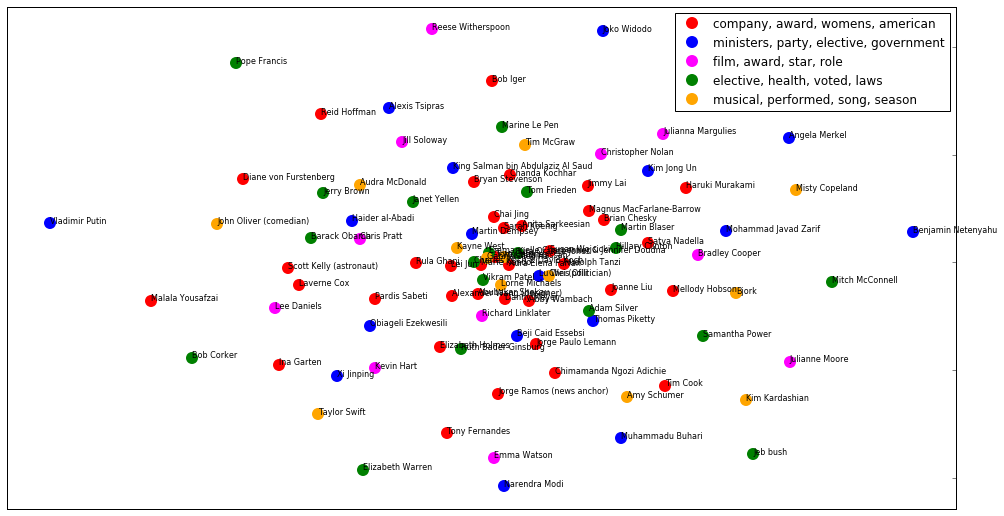

In [168]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=names)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

# We can save plot to file
plt.savefig('kMean_clusters.png', dpi=300)

In [169]:
plt.close()

# V. Hierarchical document clustering

Let's now use Ward clustering algorithm because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. We use the precomputed cosine distance matrix (cos_dist) to calclate a linkage_matrix, which we plot as a dendrogram.
Note that this method returned 3 primary clusters, with the largest cluster being split into about 4 major subclusters. 

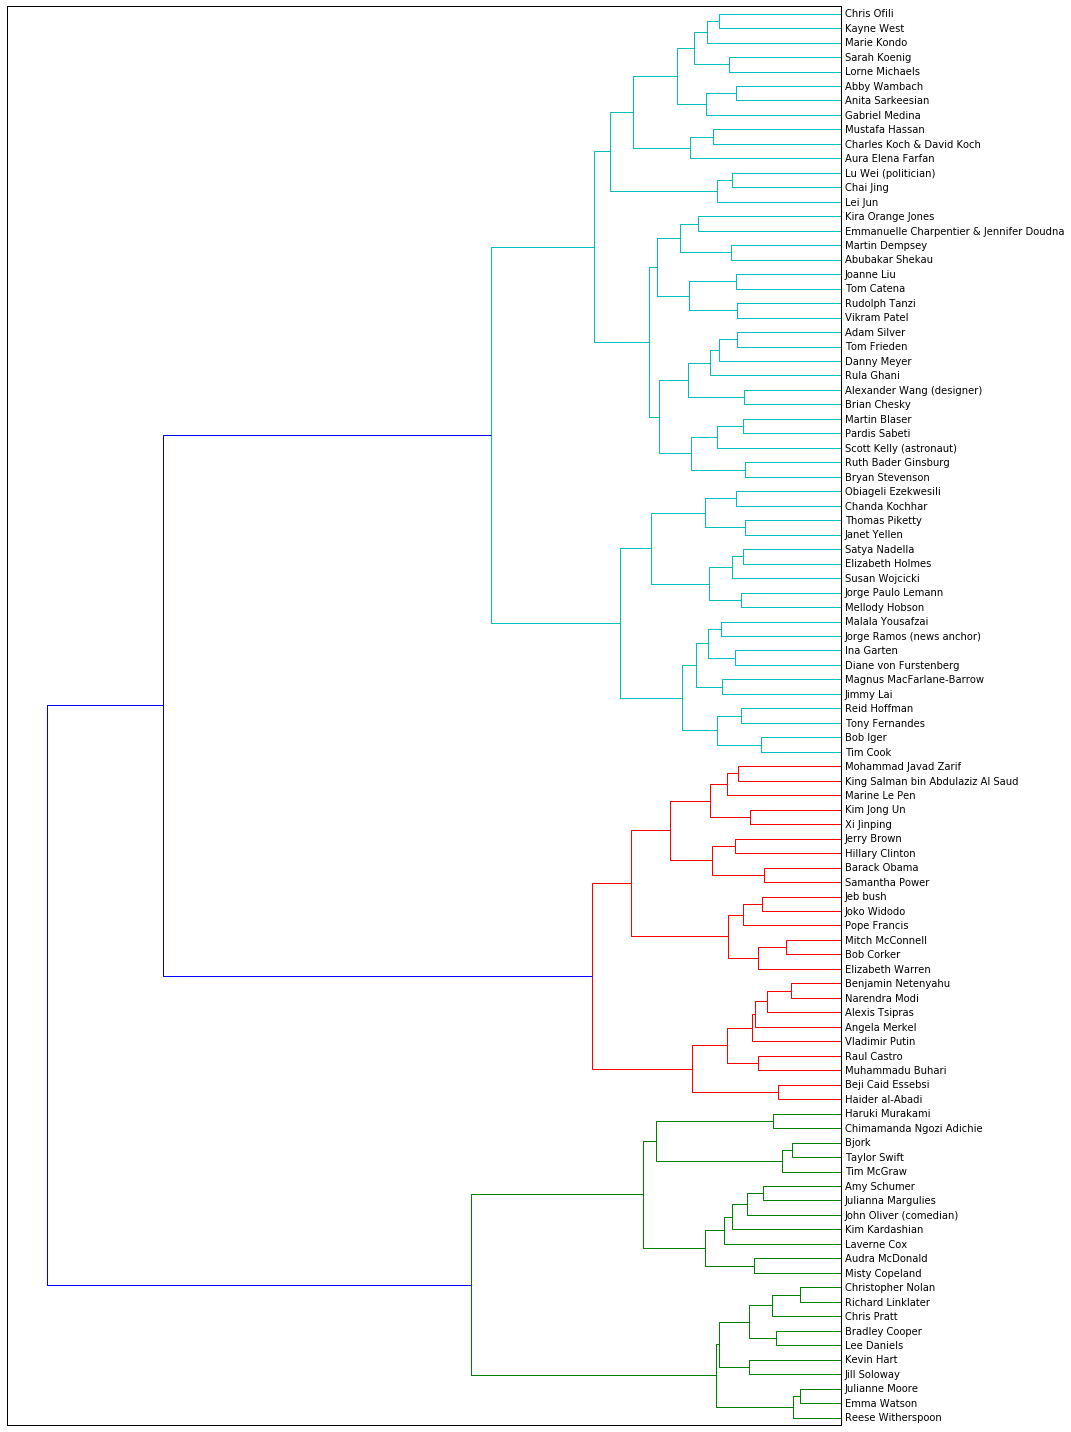

In [173]:
from scipy.cluster.hierarchy import ward, dendrogram

# Define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix = ward(cos_dist) 

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=names);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# save figure as ward_clusters
plt.savefig('hierarchical_clusters.png', dpi=300) 

In [174]:
plt.close()

# Latent Dirichlet Allocation

This section focuses on using ** Latent Dirichlet Allocation (LDA) ** to learn yet more about the hidden structure within the 100 biographies. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. For this implementaiton of LDA we use the Gensim pacakage. We preprocess the biography a bit differently here and define a function to remove any proper noun.

In [176]:
import string
def strip_proppers(text):
    # First tokenize by sentence, then by word to ensure that punctuation is caught 
    # as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if 
              word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else 
                    i for i in tokens]).strip()

In [177]:
# Strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    # Use NLTK's part of speech tagger
    tagged = pos_tag(text.split()) 
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [178]:
from gensim import corpora, models, similarities 

In [185]:
# Remove proper names ...
%time preprocess = [strip_proppers(doc) for doc in bio_list]

# ... tokenize ...
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

# ... and remove stop words 
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 1.63 s, sys: 2.44 ms, total: 1.63 s
Wall time: 1.62 s
CPU times: user 6.16 s, sys: 4.05 ms, total: 6.16 s
Wall time: 6.15 s
CPU times: user 1.01 s, sys: 4.7 ms, total: 1.02 s
Wall time: 1.01 s


In [186]:
# Create a Gensim dictionary from the texts ...
dictionary = corpora.Dictionary(texts)

# ... remove extremes (similar to the min/max df step used when creating the tf-idf matrix) ...
dictionary.filter_extremes(no_below=1, no_above=0.8)

# ... and convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

The actual model runs below. We take 100 passes to ensure convergence. The chunksize is larger than the corpus so basically all biographies are used per pass. It is possible to  optimize this, and Gensim has the capacity to run in parallel. 

In [187]:
%time lda = models.LdaModel(corpus, num_topics=5,id2word=dictionary,update_every=5,chunksize=10000, passes=100)

CPU times: user 5min 13s, sys: 6min 39s, total: 11min 53s
Wall time: 4min 45s


Each topic has a set of words that defines it, along with a certain probability.

In [188]:
lda.show_topics()

[(0,
  u'0.015*film + 0.007*award + 0.006*perform + 0.006*role + 0.005*releas + 0.005*music + 0.004*album + 0.004*best + 0.004*bjrk + 0.004*nolan'),
 (1,
  u'0.007*netanyahu + 0.006*brown + 0.005*elect + 0.005*govern + 0.005*minist + 0.004*kim + 0.004*parti + 0.004*modi + 0.004*would + 0.003*said'),
 (2,
  u'0.014*putin + 0.013*swift + 0.006*award + 0.005*russia + 0.005*murakami + 0.004*health + 0.004*countri + 0.004*ginsburg + 0.004*russian + 0.003*music'),
 (3,
  u'0.009*west + 0.006*franci + 0.006*pope + 0.005*album + 0.005*bergoglio + 0.004*wambach + 0.004*dure + 0.004*merkel + 0.004*mcgraw + 0.004*goal'),
 (4,
  u'0.007*presid + 0.006*obama + 0.006*clinton + 0.004*elect + 0.004*us + 0.004*vote + 0.004*nation + 0.004*bush + 0.004*parti + 0.004*polit')]

Here we convert the topics into just a list of the top 10 words in each topic. We can see a similar breakdown of topics as we identified using k-means 

In [189]:
topics_list = lda.show_topics(formatted=False, num_words=10)

In [190]:
lda_list = []
for k in topics_list:
    aux_list = []
    for m in (k[1]):
        #print (str(m[0])),
        aux_list.append(str(m[0]))
    lda_list.append(aux_list)
    #print ("======")

In [191]:
for k in np.array(lda_list):
    print (k)
    print ()

['film' 'award' 'perform' 'role' 'releas' 'music' 'album' 'best' 'bjrk'
 'nolan']

['netanyahu' 'brown' 'elect' 'govern' 'minist' 'kim' 'parti' 'modi' 'would'
 'said']

['putin' 'swift' 'award' 'russia' 'murakami' 'health' 'countri' 'ginsburg'
 'russian' 'music']

['west' 'franci' 'pope' 'album' 'bergoglio' 'wambach' 'dure' 'merkel'
 'mcgraw' 'goal']

['presid' 'obama' 'clinton' 'elect' 'us' 'vote' 'nation' 'bush' 'parti'
 'polit']

